In [13]:
import numpy as np
import time
import operator as op
from functools import reduce
import matplotlib.pyplot as plt
from cyipopt import minimize_ipopt
from jax import jit, grad, jacfwd, jacrev


# Multi Dimension Waypoint Time Optimization

In [ ]:
def ncr(n, r):
    r = min(r, n-r)
    numer = reduce(op.mul, range(n, n-r, -1), 1)
    denom = reduce(op.mul, range(1, r+1), 1)
    return numer // denom  # or / in Python 2


#Adding Dimension we assume the SFC is now something like sfc[[xl,xu,yl,yu,zl,zu],...] Repeated
#This should be fairly straight forward I believe?
#We assume our optimization variables
#for 3 splines labels are cx0,cy0,cz0, cx1,cy1,cz1,cx2,cy2,cz2, time0, time1, time2
#Multi Dimensional Optimization
class bernWaypointObj(object):
    def __init__(self, sfc, maxVel, maxAccel):
        self.sfc = sfc
        polyOrder = 5
        self.polyOrder = polyOrder
        self.numCoeff = polyOrder+1
        self.velDeriv = self.matrixDerivative(1)
        self.accDeriv = self.matrixDerivative(2)
        self.maxVel = maxVel
        self.maxAccel = maxAccel
        self.numVar = 3*(len(sfc)+1)+len(sfc) #Position/velocity/acceleration Description For each waypoint + NumTimes
        #Start of the time index
        self.timeIndex = 3*(len(sfc)+1)
        #Position 6 constraints velocity 5 acceleration 4
        #2 Constraints lower upper
        #3 Dimensions
        self.numberIneqConstr = (6+5+4)*len(sfc)*2
        self.grad= np.zeros(self.numVar)
        #Set the Gradeint to this 
        self.grad[-1*len(self.sfc):] = np.ones(len(self.sfc))
        #Matrix Inverse that converts l to u
        self.matrixInverse = np.zeros((6,6))
        self.matrixInverse[:3,0] =np.ones(3)
        self.matrixInverse[1,1] = 0.2
        self.matrixInverse[2,1] = 0.4
        self.matrixInverse[2,2] = 1/20
        self.matrixInverse[3:6,3] =np.ones(3)
        self.matrixInverse[3,4] = -0.4
        self.matrixInverse[4,4] = -0.2
        self.matrixInverse[3,5] = 1/20

    #point is a 6x1 vector containing infformatoin start_pos, start_vel, start_acc, end_pos, end_vel,end_acc 
    def convertWaypointCoeff(self, point, t):
        convert =  np.copy(self.matrixInverse)
        #Inversion indeces
        convert[1,1]*=t
        convert[2,1]*=t
        convert[2,2]*=(t*t)
        convert[3,4]*=t
        convert[4,4]*=t
        convert[3,5]*=(t*t)
        return convert @ point
    
    
    def matrixDerivative(self, order):
        n = self.polyOrder
        Dm = np.zeros((n+1,n-order+1));
        conv_filt = np.zeros(order+1);
        conv_filt[0] =-1;
        conv_filt[1] = 1
        for i in range(1,order):
            conv_filt[1:] -= conv_filt[:order]
        for i in range(n-order+1):
            q = min(i+order+1,n+1)
            for j in range(i,q):
                Dm[j, i] = conv_filt[j-i]
        if order%2==0:
            Dm= -1*Dm
        factor = 1
        for i in range(order):
            factor = (self.polyOrder-i)*factor
        return factor*Dm

    #[This obejctive x is shaped] 
    #[coeff_spline1, coeff_spine2 ... coeff_splineN, t1,t2...tN]
    def objective(self, x):
        #The Sum of all the times
        return np.sum(x[-1*len(self.sfc):])

    #Gradient of the Objective
    def gradient(self, x):
        return self.grad
   
    #Solve the bounds based on the safe flight corridor for each waypoint
    def solveBounds(self, start,end):
        bounds = []
        #Start Point Bounds
        bounds.append((start,start))
        bounds.append((0,0))
        bounds.append((0,0))
        for i in range(len(sfc)-1):
            #Solve the overlap condition
            bounds.append((max(sfc[i][0],sfc[i+1][0]),min(sfc[i][1],sfc[i+1][1])))
            bounds.append((-1*self.maxVel,self.maxVel))
            bounds.append((-1*self.maxAccel,self.maxAccel))
        #End point bounds
        bounds.append((end,end))
        bounds.append((0,0))
        bounds.append((0,0))
        #TIME 
        for i in range(len(sfc)):
            bounds.append((0.1,100))
        return bounds
    
    #Velocity and acceleration constraints
    def ineqConstraints(self, x):
        polyOrder = self.polyOrder
        timeIndex = self.timeIndex
        #Velcoity constraint/AccelerationCosntrain/Contiuity constraint
        constraints = np.zeros(self.numberIneqConstr)
        row = 0
        for i in range(len(self.sfc)):
            #Position Constraints
            coeff = self.convertWaypointCoeff(x[3*i:3*i+6], x[timeIndex+i])
            #Lower bounds
            constraints[row:row+self.polyOrder+1] = coeff - self.sfc[i][0]
            row+=self.polyOrder+1
            #Upper bounds
            constraints[row:row+self.polyOrder+1] =  self.sfc[i][1] - coeff
            row+=self.polyOrder+1
            #Velcoity Constraints
            velDeriv = (self.velDeriv.T @ coeff )/x[self.timeIndex+i]
            #Lower bounds
            constraints[row:row+self.polyOrder] = velDeriv + self.maxVel
            row+=self.polyOrder
            #Upper bounds
            constraints[row:row+self.polyOrder] =  self.maxVel - velDeriv
            row+=self.polyOrder
            #Constraint = (n*n-1)/t_i * Dm * coeff
            accelDeriv =  self.accDeriv.T @ coeff/(x[self.timeIndex+i]**2)
            constraints[row:row+self.polyOrder-1] = accelDeriv + self.maxAccel
            row+=self.polyOrder-1 
            constraints[row:row+self.polyOrder-1] =  self.maxAccel - accelDeriv 
            row+=self.polyOrder-1  
        return constraints

    #Jacobian is the gradient of the constraints
    def ineqJacobian(self, x):
        # The callback for calculating the Jacobian
        row = 0
        timeIndex = self.timeIndex
        constraints = np.zeros((self.numberIneqConstr,self.numVar))
        for i in range(len(self.sfc)):
            #Creating a conversion from waypoints to ceofficent matrices
            t = x[timeIndex+i]
            convert =  np.copy(self.matrixInverse)
            convert[1,1]*=t
            convert[2,1]*=t
            convert[2,2]*=(t*t)
            convert[3,4]*=t
            convert[4,4]*=t
            convert[3,5]*=(t*t)
            
            #Position Lower bounds
            constraints[row:row+6,3*i:3*i+6] =  convert
            constraints[row+1,timeIndex+i] =  0.2*x[3*i+1]
            constraints[row+2,timeIndex+i] =  0.4*x[3*i+1]+0.1*x[3*i+2]*t
            constraints[row+3,timeIndex+i] =  -0.4*x[3*i+4]+0.1*x[3*i+5]*t
            constraints[row+4,timeIndex+i] =  -0.2*x[3*i+4]
            row+=6
            #Position Upper bounds
            #It is the same jacobian just negative 
            constraints[row:row+6,3*i:3*i+6]   =  -1*convert
            constraints[row:row+6,timeIndex+i] =  -1*constraints[row-6:row,timeIndex+i]
            row+=6
            
            #Velocity Lower bounds
            constraints[row:row+5,3*i:3*i+6] =  (self.velDeriv.T @ convert )/t
            constraints[row+1,timeIndex+i] =  0.25*x[3*i+2]
            constraints[row+2,timeIndex+i] =  5*x[3*i]/(t*t) -0.25*x[3*i+2] - 5*x[3*i+3]/(t*t) + 0.25*x[3*i+5]
            constraints[row+3,timeIndex+i] =  -0.25*x[3*i+5]
            row+=5
            #Velocity Upper bounds
            #It is the same jacobian just negative 
            constraints[row:row+5,3*i:3*i+6]   =  -1*constraints[row-5:row,3*i:3*i+6]
            constraints[row:row+5,timeIndex+i] =  -1*constraints[row-5:row,timeIndex+i]
            row+=5

            #Acceleration Lower bounds
            constraints[row:row+4,3*i:3*i+6] =  (self.accDeriv.T @ convert)/(t*t)
            constraints[row+1,timeIndex+i] =  20*x[3*i]/(t*t*t) + 12*x[3*i+1]/(t*t) - 20*x[3*i+3]/(t*t*t) + 8*x[3*i+4]/(t*t)
            constraints[row+2,timeIndex+i] =  -20*x[3*i]/(t*t*t) + -8*x[3*i+1]/(t*t) + 20*x[3*i+3]/(t*t*t) - 12*x[3*i+4]/(t*t)
            row+=4
            #Acceleration Upper bounds
            #It is the same jacobian just negative 
            constraints[row:row+4,3*i:3*i+6]   =  -1*constraints[row-4:row,3*i:3*i+6]
            constraints[row:row+4,timeIndex+i] =  -1*constraints[row-4:row,timeIndex+i]
            row+=4
        return constraints.reshape((self.numberIneqConstr*self.numVar,1))

    
    def bernEval(self,n,i,t):
        return ncr(n,i)*((1-t)**(n-i))*(t**i)

    def evalPolynomial(self,x,t_in):
        index=0
        while(t_in-x[self.timeIndex+index])>0:
            t_in-=x[self.timeIndex+index]
            index+=1
            if index == len(self.sfc):
                return 
        #Normalize time
        coeff = self.convertWaypointCoeff(x[3*index:3*index+6], x[self.timeIndex+index])
        t_in = t_in/x[self.timeIndex+index]
        poly_eval = 0
        for i in range(6):
            poly_eval += coeff[i]*self.bernEval(self.polyOrder,i,t_in)
        return poly_eval    

        

# SINGLE DIMENSIOn Waypoint Time Optimization

In [11]:
sfc = [[-50,1],[0,1],[-10,1]]
start = -5
end = -1
print(len(sfc))
opt = bernWaypointObj(sfc, 2,10)
x0 = np.zeros(3*(len(sfc)+1)+len(sfc))
for i in range(len(sfc)):
    x0[i*3] = 0.5*(sfc[i][0]+sfc[i][1])
x0[len(sfc)*3] = end
x0[3*(len(sfc)+1):] = np.ones(len(sfc))*3
bnds = opt.solveBounds(start,end)

options = {
    'mu_strategy': 'adaptive',      # IPOPT adjusts barrier parameter dynamically
    'print_level': 3,
    'max_iter': 10000   ,        # Maximum iterations
    #'linear_solver': 'ma27' ,
}
cons = [
     {'type': 'ineq', 'fun': opt.ineqConstraints, 'jac': opt.ineqJacobian}
 ]    
start_time = time.time()
solution = minimize_ipopt(
    fun=opt.objective,
    x0=x0,
    jac=opt.gradient,
    constraints = cons,
    bounds=bnds,
    options=options
)
end_time = time.time()
execution_time = end_time - start_time

3

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

Total number of variables............................:        9
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        9
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:       90
        inequality constraints with only lower bounds:       90
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0


Number of Iterations....: 28

  

Execution time: 0.04528617858886719 seconds
Trajectory Time: 5.7999999630159715 seconds


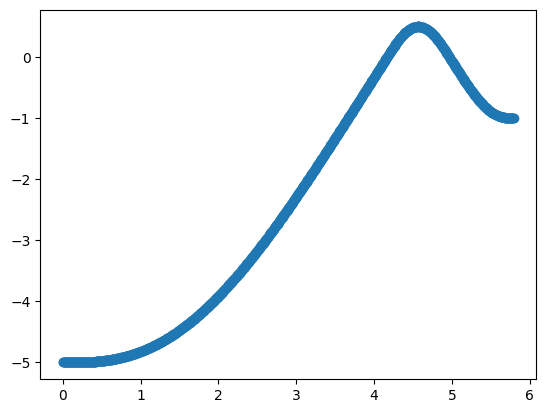

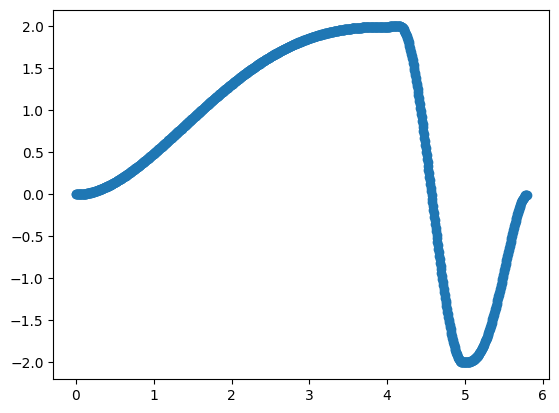

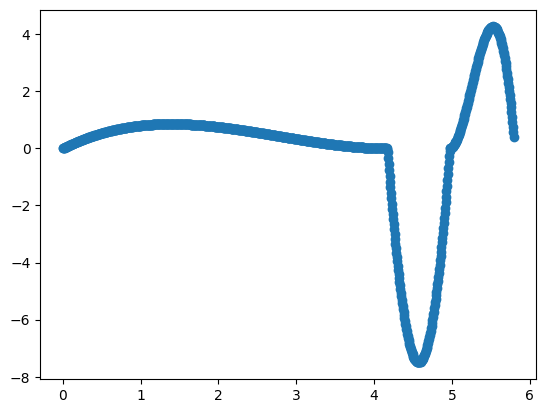

# Bernstein with Coefficients

In [ ]:
x = solution.x
print(f"Execution time: {execution_time} seconds")
x[-1*len(sfc):] = x[-1*len(sfc):]*1
timeRange = np.sum(x[-1*len(sfc):])
print(f"Trajectory Time: {timeRange} seconds")
num_samples = 1000
time_vals = np.zeros(num_samples)
x_motion = np.zeros(num_samples)
v_motion = np.zeros(num_samples)
a_motion = np.zeros(num_samples)
for i in range(num_samples):
    time_vals[i] = timeRange*i/num_samples
    x_motion[i] = opt.evalPolynomial(x,timeRange*i/num_samples)
    if i > 1:
        v_motion[i] =  (x_motion[i] -  x_motion[i-1])/(time_vals[i]-time_vals[i-1])
    if i > 2:
        a_motion[i] =  (v_motion[i] -  v_motion[i-1])/(time_vals[i]-time_vals[i-1])

plt.figure()
plt.scatter(time_vals,x_motion)
plt.figure()
plt.scatter(time_vals,v_motion)
plt.figure()
plt.scatter(time_vals,a_motion)
